# Final Report_v1

* Project Name : TW stock ML prediction with web crawler and data visualization
* Author : 楊右宇  
* Establish Date：2021.05.22  
* Last Modified Date：2021.06.13

download the graphviz first to visualize the decision tree in ML


https://www.graphviz.org/download/

In [1]:
!pip install scikit-learn

In [2]:
!pip install graphviz

In [3]:
!pip install mplfinance

# import library

In [1]:
import os
import re
import math
import time
from time import sleep
import shutil
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import mplfinance as mpf

import graphviz 

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, roc_curve, auc

from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

# Data crawling

In [2]:
def crawl_stock_tw_v1(_ticker, _year, _driver=None):
    
    '''crawl the taiwan's stock from http://www.twse.com.tw 
    (you IP will be banned while request the data too fast)'''

    # set the target website url
    url = r'https://www.twse.com.tw/zh/page/trading/exchange/STOCK_DAY.html' 
    
    # set the driver path
    if _driver == None:
        s = Service(r'C:\SDK\chromedriver_win32\chromedriver.exe')
    else:
        s = Service(_driver)

    browser = webdriver.Chrome(service=s) 
    browser.maximize_window() 
    browser.get(url) 
    sleep(1)

    # send the ticker code to the input element
    browser.find_element(by=By.XPATH, value='//*[@id="main-form"]/div/div/form/input').send_keys(str(_ticker))
    
    # Set the year by selecting the form
    Select(browser.find_element(by=By.NAME, value='yy')).select_by_value(_year)

    # Click the query button
    browser.find_element(by=By.XPATH, value='//*[@id="main-form"]/div/div/form/a[2]').click()

    for i in range(12):
        # Set the month by selecting the form
        Select(browser.find_element(by=By.NAME, value='mm')).select_by_index(i)
        # Click the query button
        browser.find_element(by=By.XPATH, value='//*[@id="main-form"]/div/div/form/a[2]').click()
        # Click the download button
        csv = WebDriverWait(browser, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "csv")))
        # sleep for a while to avoid being banned
        time.sleep(5)
        csv.click()

    time.sleep(1)
    browser.close()

In [3]:
def crawl_stock_tw_v2(_ticker, _year, _driver=None):
    
    '''crawl the taiwan's stock from http://www.twse.com.tw 
    (you IP will be banned while request the data too fast)'''

    # set the driver path
    if _driver == None:
        s = Service(r'C:\SDK\chromedriver_win32\chromedriver.exe')
    else:
        s = Service(_driver)

    browser = webdriver.Chrome(service=s) 
    browser.maximize_window() 

    # crawl the data
    for i in range(1, 13):
        # Download certain files by directly querying the URL
        url = 'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=csv&date={}{:02}01&stockNo={}'.format(_year, i, _ticker)
        browser.get(url)
        print('download data : {}-{}'.format(_year, i))
        # sleep for a while to avoid being banned
        sleep(5)

    browser.close()

In [4]:
def move_stock_tw(_ticker, _download_path=None):
    
    # Check whether the data_unmerged folder is exist
    if not os.path.isdir('data_unmerged'): 
        os.mkdir('data_unmerged')
    
    # set the destination path
    destination = os.getcwd() + '\\data_unmerged'

    # set the driver path
    if _download_path == None:
        _download_path = r"C:\Users\User\Downloads"

    source = os.listdir(_download_path)
    # Filter other files, keep only csv files
    source = [line for line in source if str(_ticker) in line] 

    # Move the downloaded file into the folder
    for s in source:
        _path = os.path.join(_download_path, s)
        shutil.move(_path, os.path.join(destination, s))

In [5]:
def merge_stock_tw(_ticker):
    
    # Check whether the data folder is exist
    if not os.path.isdir('data'): 
        os.mkdir('data')
    
    # set the source path
    _path = os.getcwd() + '\\data_unmerged\\'
    source = os.listdir(_path)
    source = [line for line in source if str(_ticker) in line]
    
    # check whether there is previous data in the data folder, if so, open it, or create a new one
    if os.path.isfile(r'./data/{}.csv'.format(str(_ticker))): 
        res = pd.read_csv(os.getcwd() + '\\data\{}.csv'.format(str(_ticker)))
    else:
        res = pd.DataFrame(columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    
    # merge all the data with same ticker code into data folder
    for s in source:
        print(s)
        # read the data in
        df = pd.read_csv(_path + s, encoding='Big5', skiprows=1)
        # Delete unwanted information
        df = df.iloc[:-4, :7]
        # rename the columns name
        df.columns = ['Date', 'Volume', 'b', 'Open', 'High', 'Low', 'Close']
        # drop the unwanted column
        df.drop('b', axis = 1, inplace = True) 
        # reorder the data
        df = df.reindex(columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
        # change the Date format rom the National Calendar to the Western Calendar
        df.loc[:, 'Date'] = df.loc[:, 'Date'].str.split('/').apply(lambda x:(str(int(x[0]) + 1911)) + '/' + x[1].removeprefix('0') + '/' + x[2].removeprefix('0'))
        # Convert quantity units
        df.loc[:, 'Volume'] = df.loc[:, 'Volume'].str.replace(',', '').astype(int) // 1000
        # merge two dataframe
        res = res.append(df, ignore_index = True)
    
    # change column Date from string to datetime so that we can sort by Date
    res['Date'] = pd.to_datetime(res['Date'])
    
    # deduplicate
    res = res.drop_duplicates(subset='Date', keep='first')
    
    # sort it with Date
    res.sort_values(by='Date', ascending=True, inplace=True)
    
    # save as a csv file
    res.to_csv(os.getcwd() + '\\data\\' + str(_ticker) + '.csv', index = False, encoding='utf-8')

# Indicators
Calculate technical analysis indicators

## Moving Average

In [20]:
def MA(_ticker, period=10, field='Close'):

    '''You can customize the daily moving average, 
    or you can calculate the moving average of the trading volume and other values.'''
    
    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)
    
    if field == 'Volume':
        res['VMA_' + str(period)] = _ticker[field].rolling(period).mean()
    else:
        res['MA_' + str(period)] = _ticker[field].rolling(period).mean()

    return res

## EMA

In [21]:
def EMA(_ticker, period=15):
    
    '''Calculate the EMA and add it to the DataFrame, the value is exponential decay'''

    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)
    
    # Add a new column to the DataFrame
    res['EMA_' + str(period)] = _ticker['Close'].ewm(span=period, adjust=False).mean()

    return res

## RSI

Relative Strength Index

In [22]:
def RSI(_ticker, period = 14):
    
    # Create temporary data
    tmp = pd.DataFrame(index=_ticker.index)

    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)
    
    # Add a new data field, the default is empty
    tmp['rise'] = np.nan

    # Search the index of a specific field
    col_rise = tmp.columns.get_loc('rise')
    col_close = _ticker.columns.get_loc('Close')

    # Calculate today's change
    for i in range(1, len(_ticker)):
        tmp.iloc[i, col_rise] = (_ticker.iloc[i, col_close] - _ticker.iloc[i - 1, col_close])

    # Create empty data column
    tmp['rise_only'] = tmp['rise']
    tmp['drop_only'] = tmp['rise']

    # Divide the heap according to the size of the value less than zero
    tmp['rise_only'].loc[tmp['rise'] < 0] = 0
    tmp['drop_only'].loc[tmp['rise'] > 0] = 0
    
    # Calculate the average change value for N days
    tmp['rise_avg'] = tmp['rise_only'].rolling(period).mean()
    tmp['drop_avg'] = tmp['drop_only'].rolling(period).mean().abs()

    # Calculate RSI
    res['RSI'] = tmp['rise_avg'] / (tmp['rise_avg'] + tmp['drop_avg']) * 100
    
    return res

## KD

In [23]:
def KD(_ticker, period = 9):

    # Create temporary data
    tmp = pd.DataFrame(index=_ticker.index)

    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)

    # Find the highest and lowest prices in N days
    tmp['max_close'] = ticker['Close'].rolling(period, min_periods=1).max()
    tmp['min_close'] = ticker['Close'].rolling(period, min_periods=1).min()

    # Calculate RSV
    tmp['RSV'] = (ticker['Close'] - tmp['min_close']) / (tmp['max_close'] - tmp['min_close']) * 100

    # Since the definition of K D is recursive, and the value is 0 ~ 100, the default is 50
    res['K'] = 50
    res['D'] = 50
    
    # Search the index of a specific field
    col_k = res.columns.get_loc('K')
    col_d = res.columns.get_loc('D')
    col_rsv = tmp.columns.get_loc('RSV')

    # Search the index of a specific field
    for i in range(1, len(_ticker)):
        res.iloc[i, col_k] = res.iloc[i - 1, col_k] * 2 / 3 + tmp.iloc[i, col_rsv] * 1 / 3
        res.iloc[i, col_d] = res.iloc[i - 1, col_d] * 2 / 3 + res.iloc[i, col_k] * 1 / 3
    
    return res

## MACD

In [24]:
def MACD(_ticker, fast_period=12, slow_period=26, signal_period=9):
    
    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)

    # Calculate fast and slow EMA
    ema_f = _ticker['Close'].ewm(span=fast_period, adjust=False).mean()
    ema_s = _ticker['Close'].ewm(span=slow_period, adjust=False).mean()
    
    # Calculate the MACD value
    res['macd_dif'] = ema_f - ema_s
    res['macd_dea'] = res['macd_dif'].ewm(span=signal_period, adjust=False).mean()
    res['macd'] = res['macd_dif'] - res['macd_dea']

    return res

## Bollinger Bands

In [25]:
def BBands(_ticker, period=20, std_num=2):
    
    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)

    # Calculate the median line, which is the 20-day MA
    res['bbands_middle'] = _ticker['Close'].rolling(period).mean()
    
    # Calculate the standard deviation
    std = _ticker['Close'].rolling(period).std(ddof=0) 
    
    # Calculate the upper and lower rails
    res['bbands_upper'] = res['bbands_middle'] + std * std_num 
    res['bbands_lower'] = res['bbands_middle'] - std * std_num

    return res

# Trading Strategy

In [26]:
def AI_rule(_ticker, buy_point_name='buy_point'):
    
    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)

    # Check to see if there is an indicator to use
    try:
        if not {'prediction'}.issubset(res.columns):
            res['prediction'] = prediction
    except Exception as e:
        print(e)
        return False

    
    # Add a blank line, set the default value to zero
    res[buy_point_name] = 0

    #Get the index value for easy calculation later
    t = res.index

    # Calculate buy and sell points
    for i in range(1, len(res)):
        if res.loc[t[i], 'prediction'] > res.loc[t[i - 1], 'prediction']:
            res.loc[res.index[i], 'buy_point'] = 1
        elif res.loc[t[i], 'prediction'] < res.loc[t[i - 1], 'prediction']:
            res.loc[res.index[i], 'buy_point'] = -1

    return res

# Plot the data with indicators

In [27]:
def plot_muti(_ticker, _title='', volume=True, buy_sell_point=False, 
    RSI=False, rsi_midline=False, rsi_bound=False, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=False, BBands=False):

    apds = []
    _panel = 1

    if len(_ticker) == 0:
        print('no data to plot')
        return

    # Draw buy and sell points, and determine whether there are buy and sell points within the drawing range to avoid mistakes
    if buy_sell_point:
        buy, sell = [np.nan], [np.nan]
        buy_b = False
        sell_b = False

        # Set buying and selling points and avoid blocking the candlestick
        for i in range(1, len(_ticker)):

            if _ticker.loc[_ticker.index[i], 'ticker_num'] > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                buy.append(_ticker.loc[_ticker.index[i], 'Low'] * 0.97)
                buy_b = True
            else:
                buy.append(np.nan)

            if _ticker.loc[_ticker.index[i], 'ticker_num'] < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                sell.append(_ticker.loc[_ticker.index[i], 'High'] * 1.03)
                sell_b = True
            else:
                sell.append(np.nan)

        # Add data to the graph
        if buy_b:
            apds += [ 
            mpf.make_addplot(buy, panel=0, type = 'scatter', color = 'blue', marker = '^', markersize = 100)
            ]

        if sell_b:
            apds += [ 
                mpf.make_addplot(sell, panel=0, type = 'scatter', color = 'darkorange', marker = 'v', markersize = 100),
            ]

    # Add RSI indicator
    if RSI:
        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['RSI'], panel = _panel - 1, color='#009393', ylabel='RSI', secondary_y=False)
        ]

        # Add upper and lower boundaries
        if rsi_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), rsi_lower_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), rsi_upper_bound), 
                    panel = _panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

        # Join the centerline
        if rsi_midline:
            apds += [mpf.make_addplot(np.full((len(_ticker)), 50), 
                    panel = _panel - 1, color='#F00078', alpha=0.5)]

    # Add KD indicator
    if KD:

        _panel += 1
        apds += [ 
            mpf.make_addplot(_ticker['K'], panel=_panel - 1, color='#0000C6', 
                ylabel='KD'),
            mpf.make_addplot(_ticker['D'], panel=_panel - 1, color='#F75000'),
            ]

        # Add upper and lower boundaries
        if kd_bound:
            apds += [
                mpf.make_addplot(np.full((len(_ticker)), kd_upper_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False),
                mpf.make_addplot(np.full((len(_ticker)), kd_lower_bound), 
                    panel=_panel - 1, color='#F00078', alpha=0.5, secondary_y=False)
            ]

    # Join MACD
    if MACD:

        _panel += 1
        apds += [
            mpf.make_addplot(_ticker['macd'], type='bar', ylabel='MACD', width=0.7, panel=_panel - 1,
                color='dimgray', alpha=1, secondary_y=False),
            mpf.make_addplot(_ticker['macd_dif'], panel=_panel - 1, color='fuchsia', secondary_y=True),
            mpf.make_addplot(_ticker['macd_dea'], panel=_panel - 1, color='b', secondary_y=True)
        ]

    # If you want to add volume, add one layer to the number of layers
    if volume:
        _panel += 1

    # Join Bollinger Bands
    if BBands:
        apds += [
            mpf.make_addplot(_ticker['bbands_middle'], panel=0, color='#9F4D95', alpha=1, width=1, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_upper'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
            mpf.make_addplot(_ticker['bbands_lower'], panel=0, color='black', alpha=0.5, width=0.8, secondary_y=False),
           
        ]

    # Set candlestick color
    my_color = mpf.make_marketcolors(up='red',      # rising color
                                     down='green',  # fall color
                                     edge='i',      # Hide candlestick edges
                                     volume='in',   # Volume in the same color
                                     inherit=True)  # Inherit other parameters

    # Set up graphics rendering
    my_style = mpf.make_mpf_style(gridaxis='both',          # set grid
                                  gridstyle='-.',           # Set the grid pattern
                                  y_on_right=True,          # y coordinate to the right
                                  marketcolors=my_color)    # Set candlestick color

    mpf.plot(_ticker, 
        type='candle',              # Set the class to draw
        num_panels=_panel,          # Set the total number of layers
        main_panel=0,               # Set the number of candlestick layer
        volume=volume,              # Set whether to draw the volume
        volume_panel=_panel - 1,    # Set Volume Layers
        addplot = apds,             # add other data
        figscale=1.5,               # Set the shape size
        style=my_style,             # Set graphics rendering
        title=_title,               # set the title
        show_nontrading=False,      # Ignore non-trading days
        tight_layout=False          # set layout
        )
    return

# Read data

In [28]:
def read_ticker_v2(_ticker_code):
    
    try:
        import os
        
        # get the current working path of this file
        path = os.getcwd()

        # get the data as a dataframe 
        res = pd.read_csv(path + '\\data\{}'.format(str(_ticker_code)))

        # change the name of columns
        res.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

        # set the column "Date" to index
        res = res.set_index('Date')

        # set index column("Date") from string to datetime.datetime
        res.index = pd.to_datetime(res.index)

        # sort index column("Date") chronologically
        res = res.sort_index()

    except Exception as e:
        print(e)
        return False

    return res

In [29]:
def get_ticker_list():
    
    import os

    # get the current working path of this file
    path = os.getcwd()

    # get all files in this path
    list = os.listdir(path + '\\data')
    
    # filter out the stock file (.csv)
    res = [file for file in list if '.csv' in file]

    return res

# Shift the data for more eigenvalue

In [30]:
def series_to_supervised(_ticker, n=1, dropnan=True):
    # if n=2 will shift each indicator with 2, 1
    # the result will have n, n-1, n-2
    
    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)
    
    # return feature numbers
    n_vars = len([x for x in _ticker if not '-' in x])
    
    for i in range(n, 0, -1):
        for j in range(n_vars):
            if not res.columns[j] + '(n-{})'.format(i) in res.columns:
                res[res.columns[j] + '(n-{})'.format(i)] = res.iloc[:, j].shift(i)
    
    
    # drop rows with NaN values
    if dropnan:
        res.dropna(axis=0, how='any', inplace=True)

    return res

# Backtesting

In [31]:
def back_track_v5(_ticker, funds=1_000_000, stop_loss_percent=0.96):

    # Add the stop price
    stop_loss = 0 

    # Get the index value for easy calculation later
    t = _ticker.index

    # Make a copy of the material and avoid modifying the original material
    res = _ticker.copy(deep=True)

    # Add a new data field to facilitate the following calculations
    res['ticker_num'] = 0
    res['income'] = 0
    res['expenditure'] = 0
    res['account'] = funds


    for i in range(1, len(_ticker)):
        
        # buy point
        if i != len(_ticker) - 1 and _ticker.loc[t[i], 'buy_point'] == 1 \
                and res.loc[t[i - 1], 'ticker_num'] == 0 :
            
            # Calculate the maximum number of sheets you can buy
            res.loc[t[i], 'ticker_num'] \
                = math.floor(res.loc[t[i - 1], 'account'] / (_ticker.loc[t[i], 'Close'] * 1.001425))
            # Calculate total cost
            res.loc[t[i], 'expenditure'] \
                = -res.loc[t[i], 'ticker_num'] * (_ticker.loc[t[i], 'Close'] * 1.001425)
            # Calculate account balance
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account'] + res.loc[t[i], 'expenditure']
            # Calculate the current stop loss and stop profit price
            stop_loss = _ticker.loc[t[i], 'Close'] * stop_loss_percent
        
        # Trailing Stop Stop Profit Sell 
        # # Unconditional sell on the last day
        elif res.loc[t[i - 1], 'ticker_num'] > 0 and _ticker.loc[t[i], 'Close'] < stop_loss\
                or i == len(_ticker) - 1 and res.loc[_ticker.index[i - 1], 'ticker_num'] > 0:
            
            # Calculate gross income
            res.loc[t[i], 'income'] \
                = res.loc[t[i - 1], 'ticker_num'] * (_ticker.loc[t[i], 'Close'] * 0.995575)
            # Update the number of existing sheets
            res.loc[t[i], 'ticker_num'] = 0
            # Calculate account balance
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account'] + res.loc[t[i], 'income']
        
        else :
            # Update the number of shares held on this day
            res.loc[t[i], 'ticker_num'] = res.loc[t[i - 1], 'ticker_num']
            # Update account balance for this day
            res.loc[t[i], 'account'] = res.loc[t[i - 1], 'account']
            # Update stop loss stop profit price
            if _ticker.loc[t[i], 'Close'] * stop_loss_percent > stop_loss:
                stop_loss = _ticker.loc[t[i], 'Close'] * stop_loss_percent
        
        # Calculate the total value with the strategy
        res.loc[t[i],'equity'] = res.loc[t[i], 'ticker_num'] * _ticker.loc[t[i], 'Close'] + res.loc[t[i], 'account']
        # Calculate the total value bought from day 1
        res.loc[t[i],'hold_equity'] = funds * _ticker.loc[t[i], 'Close'] // res.loc[t[0], 'Close']
        
    return res

# Transaction point data processing

In [32]:
def get_trade_info_v2(_ticker):

    # Record total transaction information
    detail = []
    
    # Record single column transaction information
    temp_detail = []
    
    # Buy price, easy to calculate compensation when selling
    buy_price = 0
    
    # Record starting capital for easy calculation of total remuneration
    funds = _ticker.loc[_ticker.index[0], 'account']

    for i in range(1, len(_ticker)):
        # buy info
        if _ticker.loc[_ticker.index[i], 'ticker_num'] \
            > _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
                    
            # deal Date
            temp_detail.append(_ticker.index[i])
            # Number of transactions (shares)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # Trading price
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'])
            # Transaction price (tax included)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] * 1.001425)
            # Total handling fee (handling fee plus transaction tax)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] \
                * 0.001425 * _ticker.loc[_ticker.index[i], 'ticker_num'])
            # total cost
            temp_detail.append(_ticker.loc[_ticker.index[i], 'expenditure'])
            # Remuneration for this transaction, no information at the time of purchase
            temp_detail.append(np.nan)
            # The rate of return for this transaction, there is no information at the time of purchase
            temp_detail.append(np.nan)
            # The current total transaction remuneration, no information at the time of purchase
            temp_detail.append(np.nan)
            # The current total trading rate of return, no information at the time of purchase
            temp_detail.append(np.nan)
            # Current account balance
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])
            # Update the bid price for easy calculation the next time you sell
            buy_price = _ticker.loc[_ticker.index[i], 'expenditure']

            # push data into a serial
            detail.append(temp_detail)
            # go to next row
            temp_detail = []

        # sell info
        elif _ticker.loc[_ticker.index[i], 'ticker_num'] \
            < _ticker.loc[_ticker.index[i - 1], 'ticker_num']:
            
            # deal Date
            temp_detail.append(_ticker.index[i])
            # Number of transactions (shares)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'ticker_num'] \
                - _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # Trading price
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'])
            # Transaction price (tax included)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] * 0.995575)
            # Total handling fee (handling fee plus transaction tax)
            temp_detail.append(_ticker.loc[_ticker.index[i], 'Close'] \
                * 0.004425 *  _ticker.loc[_ticker.index[i - 1], 'ticker_num'])
            # Total revenue
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'])
            # Remuneration for this transaction
            temp_detail.append(_ticker.loc[_ticker.index[i], 'income'] + buy_price)
            # Return on this transaction
            temp_detail.append((_ticker.loc[_ticker.index[i], 'income'] + buy_price) / (-buy_price) * 100)
            # Current total transaction reward
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'] - funds)
            # Current Total Trading Return
            temp_detail.append((_ticker.loc[_ticker.index[i], 'account'] - funds) / funds * 100)
            # Current account balance
            temp_detail.append(_ticker.loc[_ticker.index[i], 'account'])

            # push data into a serial
            detail.append(temp_detail)
            # go to next row
            temp_detail = []
            
    # Change the series to dataframe and return it, and add the name of each row
    return pd.DataFrame(detail, columns=['Date', 'ticker_num', 'price', 'price(with_tax)', 'tax', 
        'spend', 'profit', 'profit_rate', 'profit_sum', 'profit_sum_rate', 'account'])

# Strategy conclusion data calculation

In [33]:
def get_result(_df):

    '''Returns a list of ['Number of trades', 'Win', 'Loss', 'Win_Rate', 'rate of return']'''
    
    # Count the number of victories
    win = 0
    # count the number of defeats
    loss = 0
    
    # A reward greater than zero is a victory, otherwise a defeat
    for i in range(1, len(_df), 2):
        if _df.loc[_df.index[i], 'profit_rate'] > 0:
            win += 1
        else :
            loss += 1

    # Exception if there is no transaction
    if win + loss == 0:
        return [win + loss, win, loss, 0, 0]

    # return data
    return [win + loss, win, loss, win / (win + loss), _df.loc[_df.index[len(_df) - 1], 'profit_sum_rate']]

# Implement

## crawling data

In [34]:
# enter the ticker code of Taiwan's Listed Stock and the year 
# use the web crawler to download the data and combine it into existed data

stock = input("Enter the ticker code (2303) -> ")
year = input("Enter the year (2021) -> ")

# Get a year's worth of stock data through a crawler
crawl_stock_tw_v1(stock, year, _driver=r'C:\SDK\chromedriver_win32\chromedriver.exe')
# move the data from the download place to data_rnmerged folder in current folder
move_stock_tw(stock, _download_path=r'C:\Users\User\Downloads')
# Consolidate stocks of the same salary into one file
merge_stock_tw(stock)

Enter the ticker code (2303) -> 0050
Enter the year (2021) -> 2021
STOCK_DAY_0050_202101.csv
STOCK_DAY_0050_202102.csv
STOCK_DAY_0050_202103.csv
STOCK_DAY_0050_202104.csv
STOCK_DAY_0050_202105.csv
STOCK_DAY_0050_202106.csv
STOCK_DAY_0050_202107.csv
STOCK_DAY_0050_202108.csv
STOCK_DAY_0050_202109.csv
STOCK_DAY_0050_202110.csv
STOCK_DAY_0050_202111.csv
STOCK_DAY_0050_202112.csv


In [6]:
# get the data with list of ticker code and range of year
# Need to run for more than ten minutes
# cause we can't request from the website too fast

# stock_list = ['0050', '0056', '2303', '2308', '2317', '2330', '2353', '2357', '2454', '2609', '2834', '2886', '5351']
# stock_list = ['0056', '2303', '2317', '2330']
stock_list = ['1101', '1216', '1301', '1402', '1503', '1708', '1701', '1598', '1802', '1903', '2002', '2101']

for t in stock_list:
    for y in range(2017, 2022):
        crawl_stock_tw_v2(t, y)
    move_stock_tw(t)
    merge_stock_tw(t)


download data : 2017-1
download data : 2017-2
download data : 2017-3
download data : 2017-4
download data : 2017-5
download data : 2017-6
download data : 2017-7
download data : 2017-8
download data : 2017-9
download data : 2017-10
download data : 2017-11
download data : 2017-12
download data : 2018-1
download data : 2018-2
download data : 2018-3
download data : 2018-4
download data : 2018-5
download data : 2018-6
download data : 2018-7
download data : 2018-8
download data : 2018-9
download data : 2018-10
download data : 2018-11
download data : 2018-12
download data : 2019-1
download data : 2019-2
download data : 2019-3
download data : 2019-4
download data : 2019-5
download data : 2019-6
download data : 2019-7
download data : 2019-8
download data : 2019-9
download data : 2019-10
download data : 2019-11
download data : 2019-12
download data : 2020-1
download data : 2020-2
download data : 2020-3
download data : 2020-4
download data : 2020-5
download data : 2020-6
download data : 2020-7
do

ValueError: invalid literal for int() with base 10: '說明:'

## read the data and calculate the indicators

In [179]:
# set the target data
data = '0050'

# read data
ticker = read_ticker_v2(data + '.csv')

# calculate the indicators
ticker = MA(ticker, period=5, field='Close')
ticker = MA(ticker, period=10, field='Close')
ticker = MA(ticker, period=20, field='Close')
ticker = RSI(ticker, period = 14)
ticker = KD(ticker, period = 9)
ticker = MACD(ticker, fast_period=12, slow_period=26, signal_period=9)
ticker = BBands(ticker, period=20, std_num=2)

ticker.iloc[-5:,:]

,Open,High,Low,Close,Volume,MA_5,MA_10,MA_20,RSI,K,D,macd_dif,macd_dea,macd,bbands_middle,bbands_upper,bbands_lower
Date,,,,,,,,,,,,,,,,,
2021-12-24,143.00,143.60,142.95,143.05,12807,142.01,141.590,141.2675,59.444444,87.603915,75.390536,0.678962,0.624650,0.054312,141.2675,143.868514,138.666486
2021-12-27,143.20,144.25,143.10,144.15,6838,142.71,141.855,141.5675,62.176166,91.735943,80.839005,0.817127,0.663146,0.153982,141.5675,144.042025,139.092975
2021-12-28,144.30,145.30,144.30,145.30,22888,143.40,142.375,141.9325,64.390244,94.490629,85.389547,1.007802,0.732077,0.275725,141.9325,144.347303,139.517697
2021-12-29,145.45,146.15,145.05,145.95,22807,144.22,142.940,142.2150,68.720379,96.327086,89.035393,1.197559,0.825173,0.372385,142.2150,145.079804,139.350196
2021-12-30,145.95,146.00,145.35,145.50,6421,144.79,143.285,142.4000,66.210046,94.721202,90.930663,1.296683,0.919475,0.377208,142.4000,145.592804,139.207196


## visualize the stock data

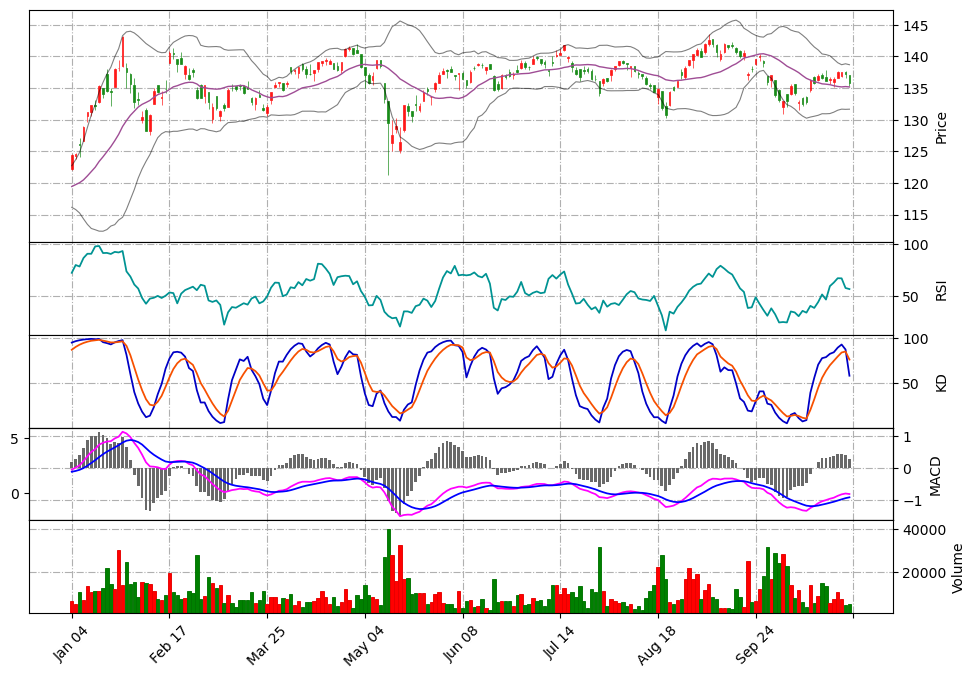

In [180]:
# slice some part to visualize
dff = ticker.loc['2021-01':'2021-10', ]

plot_muti(dff, _title='', volume=True, buy_sell_point=False, 
    RSI=True, rsi_midline=False, rsi_bound=False, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=True, kd_bound=False, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=True, BBands=True)

## get more eigenvalues

In [181]:
ticker = series_to_supervised(ticker, n=3, dropnan=False)

print(ticker.columns)
print('ticker shape :', ticker.shape)

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MA_5', 'MA_10', 'MA_20',
       'RSI', 'K', 'D', 'macd_dif', 'macd_dea', 'macd', 'bbands_middle',
       'bbands_upper', 'bbands_lower', 'Open(n-3)', 'High(n-3)', 'Low(n-3)',
       'Close(n-3)', 'Volume(n-3)', 'MA_5(n-3)', 'MA_10(n-3)', 'MA_20(n-3)',
       'RSI(n-3)', 'K(n-3)', 'D(n-3)', 'macd_dif(n-3)', 'macd_dea(n-3)',
       'macd(n-3)', 'bbands_middle(n-3)', 'bbands_upper(n-3)',
       'bbands_lower(n-3)', 'Open(n-2)', 'High(n-2)', 'Low(n-2)', 'Close(n-2)',
       'Volume(n-2)', 'MA_5(n-2)', 'MA_10(n-2)', 'MA_20(n-2)', 'RSI(n-2)',
       'K(n-2)', 'D(n-2)', 'macd_dif(n-2)', 'macd_dea(n-2)', 'macd(n-2)',
       'bbands_middle(n-2)', 'bbands_upper(n-2)', 'bbands_lower(n-2)',
       'Open(n-1)', 'High(n-1)', 'Low(n-1)', 'Close(n-1)', 'Volume(n-1)',
       'MA_5(n-1)', 'MA_10(n-1)', 'MA_20(n-1)', 'RSI(n-1)', 'K(n-1)', 'D(n-1)',
       'macd_dif(n-1)', 'macd_dea(n-1)', 'macd(n-1)', 'bbands_middle(n-1)',
       'bbands_upper(n-1)', 'bba

## Target tagging and training/test sample cuts

In [182]:
# set the n days laters price we want to predict
n_later = 5

# If n days later price is higher than today, mark 1, otherwise mark 0
ticker['week_trend'] = np.where(ticker.Close.shift(-n_later) > ticker.Close, 1, 0)

# drop the null value
ticker.dropna(axis=0, how='any', inplace=True)
print(ticker.isnull().sum())
ticker = ticker.loc[:'2021-03', ]

# split the data into train and test
split_point = int(len(ticker)*0.8)

# Cut into learning samples and test samples
train = ticker.iloc[:split_point,:].copy()
test = ticker.iloc[split_point:-5,:].copy()

# The training samples are subdivided into target sequence y and factor matrix X
train_x = train.drop('week_trend', axis = 1)
train_y = train.week_trend

# The test sample is subdivided into the target sequence y and the factor matrix X
test_x = test.drop('week_trend', axis = 1)
test_y = test.week_trend

Open                  0
High                  0
Low                   0
Close                 0
Volume                0
                     ..
macd(n-1)             0
bbands_middle(n-1)    0
bbands_upper(n-1)     0
bbands_lower(n-1)     0
week_trend            0
Length: 69, dtype: int64


# train the AI

In [183]:
# call a decision tree
model = DecisionTreeClassifier(max_depth = 6)

# train the AI
model.fit(train_x, train_y)

# Let A.I. test, prediction holds A.I.'s predictions based on the test set
prediction = model.predict(test_x)

# decition tree visualization

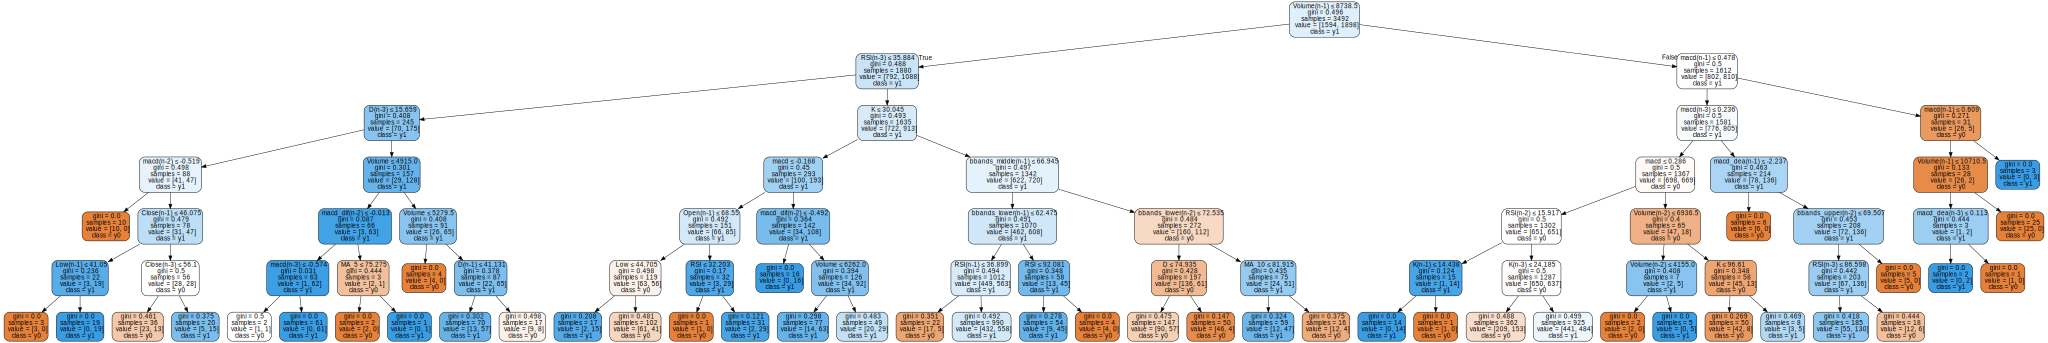

In [199]:
dot_data = export_graphviz(model, out_file = None,
                           feature_names = train_x.columns,
                           filled = True, rounded = True,
                           class_names = True,
                           special_characters = True)
graph = graphviz.Source(dot_data)

graph.format = 'png'
graph.render()
graph

# Accuracy

In [185]:
# confusion matrix
m = confusion_matrix(test_y, prediction)
print(m)
# Accuracy
model.score(test_x, test_y)

[[241 129]
 [250 249]]


0.5638665132336018

In [186]:
# Calculate the ROC curve
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, prediction)

# Calculate AUC area
auc(false_positive_rate, true_positive_rate)

0.5751746736716676

# Test a batch of depth parameters

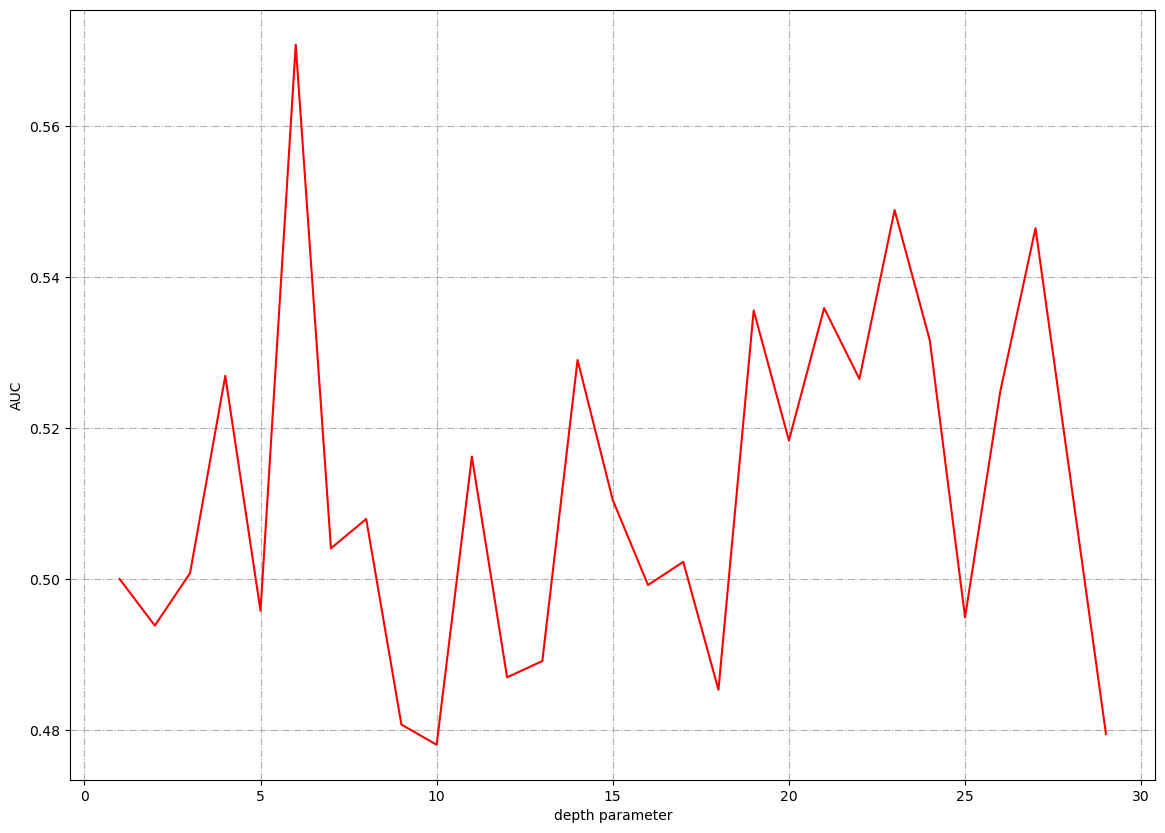

In [187]:
depth_parameters = np.arange(1, 30)

# Prepare two containers, one for the training phase AUC under all parameters; the other for the test phase AUC under all parameters
train_auc= []
test_auc = []
# Run the loop according to each parameter
for test_depth in depth_parameters:
    # According to the depth parameter, create a decision tree model named temp_model
    temp_model = DecisionTreeClassifier(max_depth = test_depth)
    # Let temp_model learn from the train learning samples
    temp_model.fit(train_x, train_y)
    # Let the learned temp_model be tested according to the train learning samples and the test test samples respectively
    train_predictions = temp_model.predict(train_x)
    test_predictions = temp_model.predict(test_x)
    # Calculate the AUC of the learning sample and record it
    false_positive_rate, true_positive_rate, thresholds = roc_curve(train_y, train_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    train_auc.append(auc_area)
    # Calculate the AUC of the test sample and record it
    false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y, test_predictions)
    auc_area = auc(false_positive_rate, true_positive_rate)
    test_auc.append(auc_area)

# Drawing visualization
plt.figure(figsize = (14,10))
plt.plot(depth_parameters, test_auc, 'r', label = 'Test AUC')
plt.ylabel('AUC')
plt.xlabel('depth parameter')
plt.show()

## backtesting

              Open    High     Low   Close  Volume    MA_5    MA_10     MA_20  \
Date                                                                            
2017-08-31   83.15   83.15   82.70   82.95    3284   82.64   82.155   81.9725   
2017-09-01   82.95   83.20   82.65   83.00    4429   82.70   82.340   82.0050   
2017-09-04   82.90   83.05   82.70   82.85    2595   82.76   82.520   82.0000   
2017-09-05   82.90   83.00   82.65   82.95    2564   82.89   82.630   82.0025   
2017-09-06   82.70   82.90   82.35   82.60    2891   82.87   82.715   82.0250   
...            ...     ...     ...     ...     ...     ...      ...       ...   
2021-03-18  135.10  136.05  134.80  134.90    7050  134.92  133.635  135.0925   
2021-03-19  133.45  133.50  132.30  132.80   10691  134.43  133.720  134.7150   
2021-03-22  132.40  133.60  131.60  133.40    5510  134.13  133.875  134.4425   
2021-03-23  133.90  134.70  133.60  133.60    6994  133.78  134.100  134.1825   
2021-03-24  131.80  132.45  

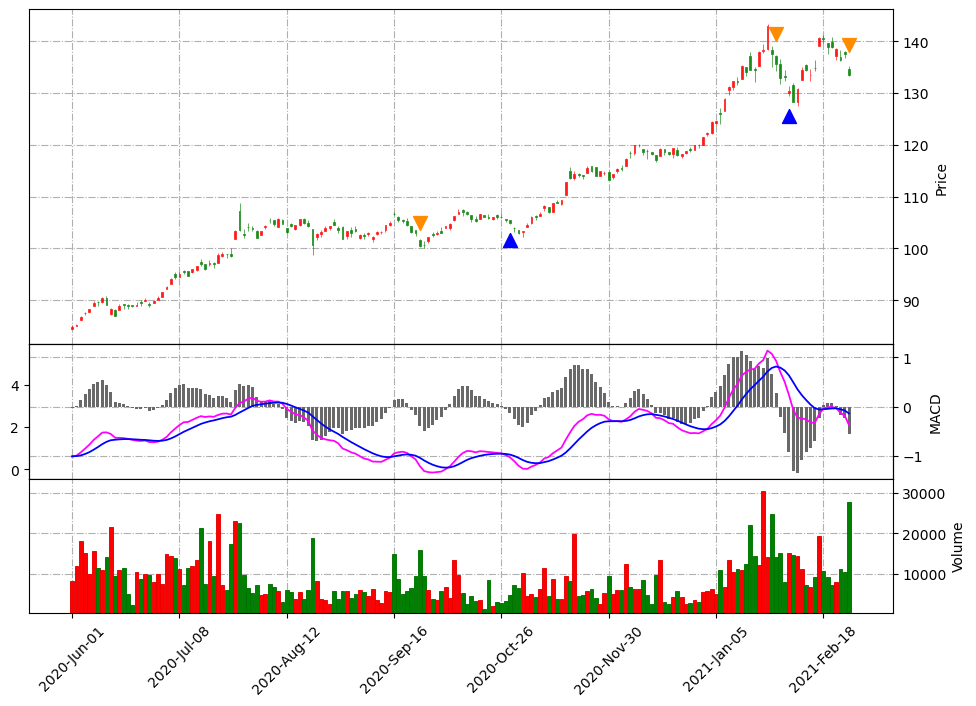

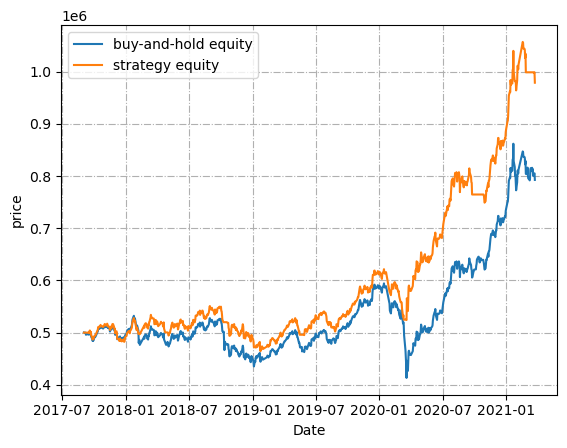

         Date  ticker_num   price  price(with_tax)          tax  \
0  2017-09-15        6063   82.35        82.467349   711.485471   
1  2017-12-06       -6063   80.85        80.492239  2169.106459   
2  2017-12-11        5979   81.50        81.616138   694.386113   
3  2018-02-05       -5979   83.60        83.230070  2211.811470   
4  2018-02-09        6286   79.05        79.162646   708.094328   
5  2018-04-23       -6286   79.95        79.596221  2223.853223   
6  2018-05-02        6293   79.40        79.513145   712.021485   
7  2018-10-08       -6293   83.00        82.632725  2311.261575   
8  2018-10-19        6548   79.30        79.413003   739.940370   
9  2018-12-06       -6548   75.10        74.767682  2176.014990   
10 2018-12-10        6567   74.45        74.556091   696.701239   
11 2019-01-04       -6567   72.20        71.880515  2098.057995   
12 2019-01-10        6301   74.80        74.906590   671.623590   
13 2019-05-16       -6301   79.05        78.700204  2204.06617

In [195]:
# use the testing data to backtesting the AI
test_x['prediction'] = prediction

# Mark the buy and sell points of the trading strategy
ticker = AI_rule(test_x, buy_point_name='buy_point')
print(ticker)

# Data backtesting
ticker = back_track_v5(ticker, 500_000, stop_loss_percent=0.95) # 起始資金為五十萬

# plot
dff = ticker.loc['2020-06':'2021-02', ]
plot_muti(dff, _title='', volume=True, buy_sell_point=True, 
    RSI=False, rsi_midline=True, rsi_bound=True, rsi_upper_bound=85, rsi_lower_bound=15, 
    KD=False, kd_bound=True, kd_upper_bound=85, kd_lower_bound=15, 
    MACD=True, BBands=False)

# compare the result with buy-and-hold equity and strategy equity
plt.plot(ticker['hold_equity'], label='buy-and-hold equity')
plt.plot(ticker['equity'], label='strategy equity')
plt.xlabel('Date')
plt.ylabel('price')
plt.legend()
plt.show()

# Calculate transaction information
result = get_trade_info_v2(ticker)
print(result)

# Calculate ROI
profit = get_result(result)
print()
print('win Rate :', round(profit[3], 2))
print('Return of Investment :', round(profit[4], 2), '%')

# result.to_csv(data + '_result.csv')